In [1]:
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

caffe.set_device(0)
caffe.set_mode_gpu()

import numpy as np
from pylab import *
%matplotlib inline
import tempfile

# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [16]:
import os
# os.chdir('examples')
weights = os.path.join(caffe_root, 'models/VGG_ILSVRC_16_layers/VGG_ILSVRC_16_layers.caffemodel')
assert os.path.exists(weights)

In [6]:
# full_dataset = True
# if full_dataset:
#     NUM_STYLE_IMAGES = NUM_STYLE_LABELS = -1
# else:
#     NUM_STYLE_IMAGES =2005
#     NUM_STYLE_LABELS = 5
NUM_STYLE_LABELS = 200
# Load ImageNet labels to imagenet_labels
# imagenet_label_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
# imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
# assert len(imagenet_labels) == 1000
# print 'Loaded ImageNet labels:\n', '\n'.join(imagenet_labels[:10] + ['...'])

# Load style labels to style_labels
#list1=[71,72,94,148,161]
style_labels=range(1,201)
# style_label_file = caffe_root + 'data/bird_classification/classes.txt'
# t=np.loadtxt(style_label_file, str, delimiter='\t')

# style_labels =[t[i].split('.')[1] for i in range(len(t))]
# style_labels =list(np.loadtxt(style_label_file, str, delimiter='\t'))
# if NUM_STYLE_LABELS > 0:
#     style_labels = style_labels[:NUM_STYLE_LABELS]
print '\nLoaded style labels:\n',style_labels


Loaded style labels:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200]


In [1]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1_1, n.relu1_1 = conv_relu(n.data,ks=3, nout=64, pad=1,param=param)
    n.conv1_2, n.relu1_2 = conv_relu(n.relu1_1, ks=3 ,nout=64, pad=1,param=param)
    n.pool1 = max_pool(n.relu1_2, ks=2, stride=2)
    n.conv2_1, n.relu2_1 = conv_relu(n.pool1,ks=3,  nout=128, pad=1, param=param)
    n.conv2_2, n.relu2_2 = conv_relu(n.relu2_1, ks=3, nout=128, pad=1,param=param)
    n.pool2 = max_pool(n.relu2_2, ks=2, stride=2)
    n.conv3_1, n.relu3_1 = conv_relu(n.pool2, ks=3, nout=256, pad=1,param=param)
    n.conv3_2, n.relu3_2 = conv_relu(n.relu3_1, ks=3, nout=256, pad=1,param=param)
    n.conv3_3, n.relu3_3 = conv_relu(n.relu3_2, ks=3, nout=256, pad=1,param=param)
    n.pool3 = max_pool(n.relu3_3, ks=2, stride=2)
    n.conv4_1, n.relu4_1 = conv_relu(n.pool3,  ks=3, nout=512, pad=1,param=param)
    n.conv4_2, n.relu4_2 = conv_relu(n.relu4_1, ks=3, nout=512, pad=1,param=param)
    n.conv4_3, n.relu4_3 = conv_relu(n.relu4_2, ks=3, nout=512, pad=1,param=param)
    n.pool4 = max_pool(n.relu4_3, ks=2, stride=2)
    n.conv5_1, n.relu5_1 = conv_relu(n.pool4, ks=3, nout=512, pad=1,param=param)
    n.conv5_2, n.relu5_2 = conv_relu(n.relu5_1, ks=3, nout=512, pad=1,param=param)
    n.conv5_3, n.relu5_3 = conv_relu(n.relu5_2, ks=3, nout=512, pad=1,param=param)
    n.pool5 = max_pool(n.relu5_3, ks=2, stride=2)  
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    with open('../models/finetune_bird_recognition/train_val.prototxt', "w")as f:
        f.write(str(n.to_proto()))
        return f.name

ImportError: No module named caffe

In [ ]:
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 256, 256]))
imagenet_net_filename = caffenet(data=dummy_data, train=False)
imagenet_net = caffe.Net(imagenet_net_filename, weights, caffe.TEST)

In [5]:
# dummy_data = L.DummyData(shape=dict(dim=[1, 3, 224, 224]))
# imagenet_net_filename = caffenet(data=dummy_data, train=False)
# imagenet_net = caffe.Net(imagenet_net_filename, weights, caffe.TEST)
# imagenet_net_filename

In [9]:
def style_net(train=True, learn_all=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'test'
    source = caffe_root + 'data/bird_classification/%s_all.txt' % subset
    transform_param = dict(mirror=train, crop_size=224,
        mean_file=caffe_root + 'data/ilsvrc12/imagenet_mean.binaryproto')
    style_data, style_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=50, new_height=256, new_width=256, ntop=2)
    return caffenet(data=style_data, label=style_label, train=train,
                    num_classes=NUM_STYLE_LABELS,
                    classifier_name='fc8_birdrecog',
                    learn_all=learn_all)

In [26]:
# untrained_style_net = caffe.Net(style_net(train=False, subset='train'),
#                                 weights, caffe.TEST)

# untrained_style_net.forward()
# style_data_batch = untrained_style_net.blobs['data'].data.copy()
# style_label_batch = np.array(untrained_style_net.blobs['label'].data, dtype=np.int32)

In [21]:
def disp_preds(net, image, labels, k=5, name='ImageNet'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1_1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print 'top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))

def disp_imagenet_preds(net, image):
    disp_preds(net, image, imagenet_labels, name='VGG16Net')

def disp_style_preds(net, image):
    disp_preds(net, image, style_labels, name='style')

In [17]:
untrained_style_net = caffe.Net(style_net(train=False, subset='train'),
                                weights, caffe.TEST)
untrained_style_net.forward()
style_data_batch = untrained_style_net.blobs['data'].data.copy()
style_label_batch = np.array(untrained_style_net.blobs['label'].data, dtype=np.int32)

actual label = 2


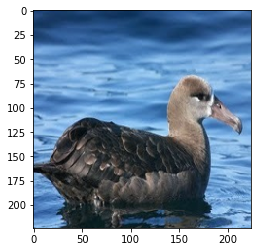

In [18]:
batch_index = 10
image = style_data_batch[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', style_labels[style_label_batch[batch_index]]

In [22]:
disp_style_preds(untrained_style_net, image)

top 5 predicted style labels =
	(1)  0.50% 1
	(2)  0.50% 128
	(3)  0.50% 129
	(4)  0.50% 130
	(5)  0.50% 131


In [10]:
# disp_imagenet_preds(imagenet_net, image)

In [11]:
# disp_style_preds(untrained_style_net, image)

In [12]:
# diff = untrained_style_net.blobs['fc7'].data[0] - imagenet_net.blobs['fc7'].data[0]
# error = (diff ** 2).sum()
# assert error < 1e-8

In [13]:
# del untrained_style_net

In [24]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 1000
    s.snapshot_prefix = caffe_root + 'models/finetune_bird_recognition/bird_recognition'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    with open('../models/finetune_bird_recognition/solver.prototxt', "w") as f:
        f.write(str(s))
        return f.name

In [25]:
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%.3f%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = caffe_root + 'models/finetune_bird_recognition'
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

In [26]:
style_solver_filename = solver(style_net(train=True))
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(weights)

In [13]:
niter = 200  # number of iterations to train

# Reset style_solver as before.
style_solver_filename = solver(style_net(train=True))
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(weights)

# For reference, we also create a solver that isn't initialized from
# the pretrained ImageNet weights.
scratch_style_solver_filename = solver(style_net(train=True))
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', style_solver),
           ('scratch', scratch_style_solver)]
loss, acc, weights = run_solvers(niter, solvers)
print 'Done.'

train_loss, scratch_train_loss = loss['pretrained'], loss['scratch']
train_acc, scratch_train_acc = acc['pretrained'], acc['scratch']
style_weights, scratch_style_weights = weights['pretrained'], weights['scratch']

# Delete solvers to save memory.
del style_solver, scratch_style_solver, solvers

Running solvers for 200 iterations...
  0) pretrained: loss=5.298, acc=0.000%; scratch: loss=5.298, acc=0.000%
 10) pretrained: loss=7.335, acc=0.000%; scratch: loss=5.306, acc=0.000%
 20) pretrained: loss=14.263, acc=0.000%; scratch: loss=5.329, acc=0.000%
 30) pretrained: loss=11.170, acc=0.000%; scratch: loss=5.359, acc=0.000%
 40) pretrained: loss=16.673, acc=0.000%; scratch: loss=5.381, acc=0.000%
 50) pretrained: loss=15.751, acc=0.000%; scratch: loss=5.407, acc=0.000%
 60) pretrained: loss=16.111, acc=0.000%; scratch: loss=5.435, acc=0.000%
 70) pretrained: loss=16.734, acc=0.000%; scratch: loss=5.455, acc=0.000%
 80) pretrained: loss=16.387, acc=0.000%; scratch: loss=5.475, acc=0.000%
 90) pretrained: loss=18.639, acc=0.000%; scratch: loss=5.499, acc=0.000%
100) pretrained: loss=17.251, acc=0.000%; scratch: loss=5.519, acc=0.000%
110) pretrained: loss=17.249, acc=0.000%; scratch: loss=5.537, acc=0.000%
120) pretrained: loss=5.967, acc=0.000%; scratch: loss=5.314, acc=0.000%
130

In [28]:
net_full_conv = caffe.Net('../models/finetune_bird_recognition/train_val.prototxt', 
                          '../models/finetune_bird_recognition/weights.pretrained.caffemodel',
                          caffe.TEST)

In [36]:
for layer_name, blob in net_full_conv.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 224, 224)
label	(50,)
label_data_1_split_0	(50,)
label_data_1_split_1	(50,)
conv1_1	(50, 64, 224, 224)
conv1_2	(50, 64, 224, 224)
pool1	(50, 64, 112, 112)
conv2_1	(50, 128, 112, 112)
conv2_2	(50, 128, 112, 112)
pool2	(50, 128, 56, 56)
conv3_1	(50, 256, 56, 56)
conv3_2	(50, 256, 56, 56)
conv3_3	(50, 256, 56, 56)
pool3	(50, 256, 28, 28)
conv4_1	(50, 512, 28, 28)
conv4_2	(50, 512, 28, 28)
conv4_3	(50, 512, 28, 28)
pool4	(50, 512, 14, 14)
conv5_1	(50, 512, 14, 14)
conv5_2	(50, 512, 14, 14)
conv5_3	(50, 512, 14, 14)
pool5	(50, 512, 7, 7)
fc6	(50, 4096)
fc7	(50, 4096)
fc8_birdrecog	(50, 200)
fc8_birdrecog_fc8_birdrecog_0_split_0	(50, 200)
fc8_birdrecog_fc8_birdrecog_0_split_1	(50, 200)
loss	()
acc	()


In [37]:
for layer_name, param in net_full_conv.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1_1	(64, 3, 3, 3) (64,)
conv1_2	(64, 64, 3, 3) (64,)
conv2_1	(128, 64, 3, 3) (128,)
conv2_2	(128, 128, 3, 3) (128,)
conv3_1	(256, 128, 3, 3) (256,)
conv3_2	(256, 256, 3, 3) (256,)
conv3_3	(256, 256, 3, 3) (256,)
conv4_1	(512, 256, 3, 3) (512,)
conv4_2	(512, 512, 3, 3) (512,)
conv4_3	(512, 512, 3, 3) (512,)
conv5_1	(512, 512, 3, 3) (512,)
conv5_2	(512, 512, 3, 3) (512,)
conv5_3	(512, 512, 3, 3) (512,)
fc6	(4096, 25088) (4096,)
fc7	(4096, 4096) (4096,)
fc8_birdrecog	(200, 4096) (200,)


In [30]:
im = caffe.io.load_image('/home/ybdong/caffe/data/bird_classification/images/042.Vermilion_Flycatcher/Vermilion_Flycatcher_0020_42498.jpg')
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
transformer.set_mean('data', np.load('../python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)
# net_full_conv.blobs['data'].data[0, ...] = im
net_full_conv.forward();
# make classification map by forward and print prediction indices at each location
#net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]));

In [38]:
from skimage.measure import *
feat2 = net_full_conv.blobs['pool5'].data[0,:]
data2 = feat2.transpose((1,2,0))
data2 = np.array(data2)
data2=np.sum(data2,axis=2)
tmp_mean2 = np.mean(np.mean(data2));
highlight2=data2>tmp_mean2
# data2[data2<tmp_mean2]=0
mask,num=label(highlight2,return_num = True)
mask[highlight2==False]=0
a=[]
for i in range(1,num):
     a.append(mask.reshape(-1).tolist().count(i))
maxl=(a.index(max(a))+1)
mask[mask!=maxl]=0
plt.figure(num='astronaut',figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0])); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(data2); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(highlight2); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(mask); plt.axis('off')

ValueError: max() arg is an empty sequence

(-0.5, 223.5, 223.5, -0.5)

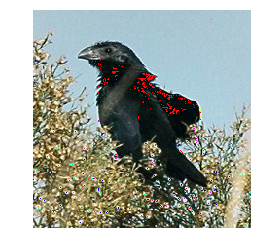

In [31]:
net_full_conv.forward();


plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0])); plt.axis('off')

In [34]:
net_full_conv.blobs['label'].data

array([ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.], dtype=float32)

In [35]:
net_full_conv.blobs['fc8_birdrecog'].data

array([[ -1.38446518e+02,  -2.05159454e+02,  -2.43843628e+02, ...,
         -3.59673119e+00,  -1.19000144e-01,  -2.57995892e+00],
       [ -1.49939819e+02,  -2.23986542e+02,  -2.96785797e+02, ...,
         -4.25689363e+00,  -1.10884953e+00,  -2.21358085e+00],
       [ -1.27939362e+02,  -1.98709061e+02,  -2.47201447e+02, ...,
         -4.64099216e+00,  -1.38395488e+00,  -2.76484871e+00],
       ..., 
       [ -1.86293198e+02,  -2.93130676e+02,  -3.63849030e+02, ...,
         -4.04368019e+00,  -1.13431072e+00,  -3.27447081e+00],
       [ -1.99358856e+02,  -3.15994110e+02,  -3.96927002e+02, ...,
         -4.08125448e+00,  -2.09142280e+00,  -3.43608189e+00],
       [ -1.79078537e+02,  -3.13850586e+02,  -3.92424927e+02, ...,
         -5.84732294e+00,  -3.60950804e+00,  -4.46349096e+00]], dtype=float32)

(-0.5, 13.5, 13.5, -0.5)

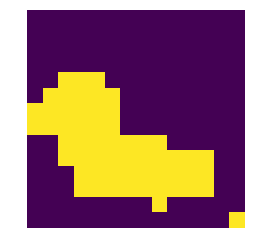

In [86]:
tmp_mean2 = np.mean(np.mean(data2));
highlight2=data2>tmp_mean2
plt.imshow(highlight2); plt.axis('off')

In [14]:
def eval_style_net(weights, test_iters=10):
    test_net = caffe.Net(style_net(train=False), weights, caffe.TEST)
    accuracy = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    return test_net, accuracy

In [ ]:
test_net, accuracy = eval_style_net(style_weights)
print 'Accuracy, trained from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_style_net(scratch_style_weights)
print 'Accuracy, trained from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

In [ ]:
batch_index = 1
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', style_labels[int(test_net.blobs['label'].data[batch_index])]
disp_style_preds(test_net, image)

In [ ]:
def disp_preds(net, image, labels, k=5, name='ImageNet'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print 'top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))

def disp_imagenet_preds(net, image):
    disp_preds(net, image, imagenet_labels, name='ImageNet')

def disp_style_preds(net, image):
    disp_preds(net, image, style_labels, name='style')

In [ ]:
for image in images:
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]

In [ ]:
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 227, 227]))  #图片数据转化好的
imagenet_net_filename = caffenet(data=dummy_data, train=False)
imagenet_net = caffe.Net(imagenet_net_filename, weights, caffe.TEST)  # 新weight

In [ ]:
import numpy as np
import pandas as pd
from pandas import  DataFrame
f = open("D:/biye/shuju/qqqq.txt")             # 返回一个文件对象  
line = f.readline()          # 调用文件的 readline()方法
#     计算概率
b=line.split('/')[-1].split(".")[0]
data = DataFrame(np.arange(90).reshape(30,3),columns=list('wxy'))
data['w']=b
data['x']=list(range(1,31))

for line in f:
#     计算概率    print (line)
    b=line.split('/')[-1].split(".")[0]
    data1 = DataFrame(np.arange(90).reshape(30,3),columns=list('wxy'))

    data1['w']=b
    data1['x']=list(range(1,31))
    data=pd.concat([data,data1])

f.close()

In [ ]:
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)

In [11]:
blobs = ('loss', 'acc')

In [12]:
blobs

('loss', 'acc')

In [28]:
solvers=[('name1',5),('name', 5)]


In [29]:
solvers

[('name1', 5), ('name', 5)]

In [30]:
blobs = ('loss', 'acc')
loss, acc = ({name: np.zeros(10) for name, _ in solvers}
                 for _ in blobs)

In [31]:
{name: np.zeros(10) for name, _ in solvers}

{'name': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'name1': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

In [24]:
loss[('name1',
  'solver1')]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [12]:
acc

{('name1',
  'solver1'): array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}